## Connect to drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


## libraries

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import cv2
from PIL import Image
import glob as gb
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, BatchNormalization, Dropout, ZeroPadding2D, MaxPooling2D
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
sns.set(rc={'figure.figsize':(15,10)})

# get the data

In [3]:
classes = ['NORMAL', 'PNEUMONIA']
img_size = 227

### Function to get images

In [4]:
def get_images(path):
  data = []
  for label in classes:
    # get all images in this file
    images = gb.glob(pathname=str(path + label + '/*.jpeg'))
    # get the index
    class_num = classes.index(label)
    # loop in all images
    for image in images:
      image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
      # get the width and height of image
      width, height = Image.open(image).size
      # to check if all image could resize
      if width >= 227 and height >= 227:
        resized_img = cv2.resize(image_array, (img_size, img_size))
        data.append([resized_img, class_num])
  return np.array(data)

In [5]:
train = get_images('/gdrive/My Drive/chest_xray/train/')
test = get_images('/gdrive/My Drive/chest_xray/test/')
val = get_images('/gdrive/My Drive/chest_xray/val/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Get all images and append in one varibale for image and one for label

In [34]:
x = []
y = []

for feature, label in train:
    x.append(feature)
    y.append(label)

for feature, label in test:
    x.append(feature)
    y.append(label)
    
for feature, label in val:
    x.append(feature)
    y.append(label)

# Convert to array and scale

In [35]:
x = np.array(x) / 255

In [36]:
y = np.array(y)

In [37]:
display(x.shape)
y.shape

(5815, 227, 227)

(5815,)

# Reshap data

In [38]:
x = x.reshape(-1, 227, 227, 1)
x.shape

(5815, 227, 227, 1)

## Split data

In [39]:
x_train, xtest, y_train, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
y_train = np_utils.to_categorical(y_train)

## Model architecture

In [49]:
model = models.Sequential()

model.add(Input(shape=(227, 227, 1)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((1,1)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(ZeroPadding2D((2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))



model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation = "softmax"))

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
callback = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.25, verbose=1)]

In [52]:
history = model.fit(x_train, y_train, batch_size=8, epochs=1000, validation_split=0.2, callbacks=callback)

Epoch 1/1000
407/407 [==============================] - 26s 61ms/step - loss: 0.6344 - accuracy: 0.8633 - val_loss: 3.2273 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 2/1000
407/407 [==============================] - 24s 59ms/step - loss: 0.2654 - accuracy: 0.9119 - val_loss: 0.1919 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 3/1000
407/407 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9217
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
407/407 [==============================] - 24s 59ms/step - loss: 0.2342 - accuracy: 0.9217 - val_loss: 0.9446 - val_accuracy: 0.7064 - lr: 0.0010
Epoch 4/1000
407/407 [==============================] - 24s 59ms/step - loss: 0.1317 - accuracy: 0.9539 - val_loss: 0.1432 - val_accuracy: 0.9472 - lr: 2.5000e-04
Epoch 5/1000
407/407 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9619
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
407/407 [=================

# Evaluate data

## loss and accuracy plot

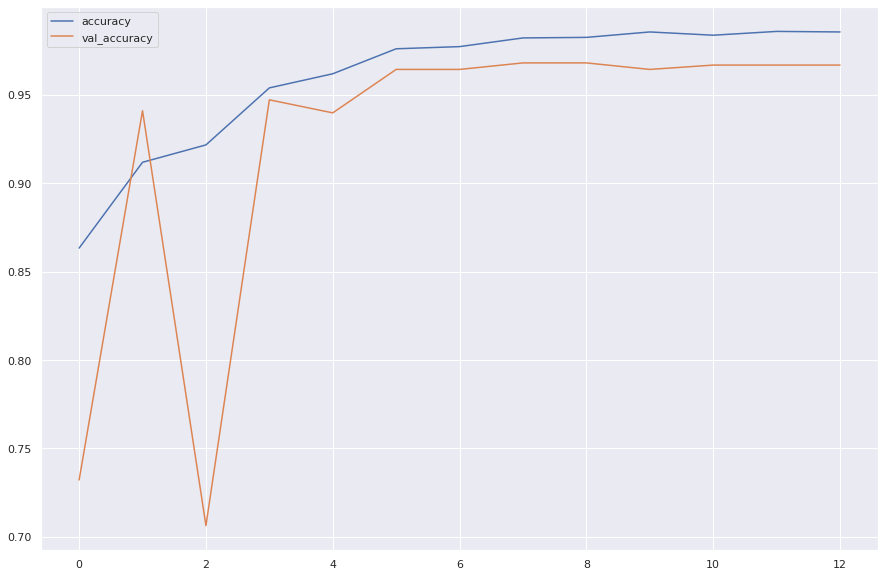

In [60]:
#plot the accuracy
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label='accuracy')
plt.plot(history_df['val_accuracy'], label='val_accuracy')
plt.legend();

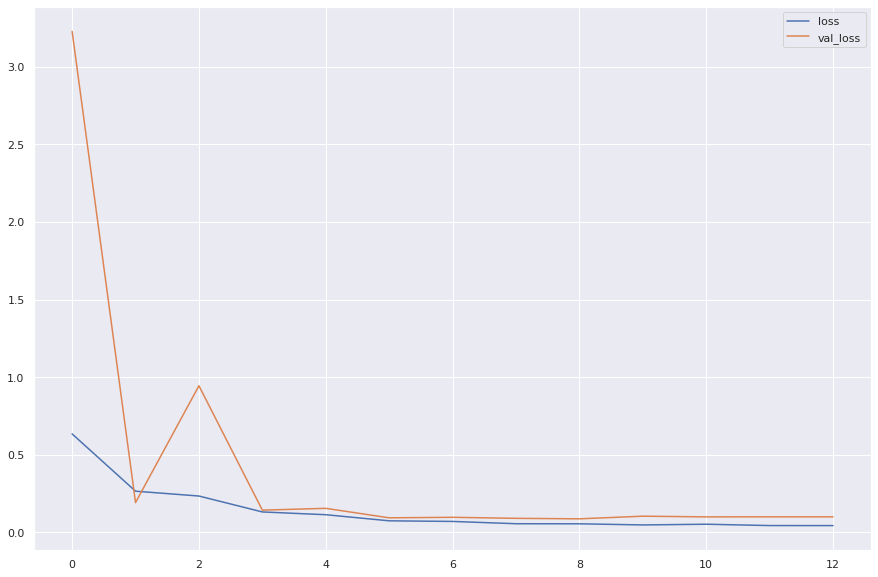

In [61]:
#plot the loss
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='val_loss')
plt.legend();

## Check evalute in train and test data

In [53]:
# Train
loss, acc = model.evaluate(x_train, y_train)
print('Train')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

128/128 [==============================] - 8s 57ms/step - loss: 0.0496 - accuracy: 0.9833
Train
loss : 0.0495695136487484
acc : 98.32924008369446


In [54]:
# Test
loss, acc = model.evaluate(xtest, np_utils.to_categorical(ytest))
print('Test')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

55/55 [==============================] - 3s 62ms/step - loss: 0.1041 - accuracy: 0.9656
Test
loss : 0.10409772396087646
acc : 96.56160473823547


In [55]:
pred = model.predict(xtest)
pred

array([[1.0000000e+00, 3.0458041e-09],
       [1.0000000e+00, 1.0795389e-08],
       [3.4046843e-06, 9.9999654e-01],
       ...,
       [5.8012889e-10, 1.0000000e+00],
       [1.9934709e-04, 9.9980062e-01],
       [7.2177773e-04, 9.9927825e-01]], dtype=float32)

In [56]:
prediction = np.argmax(pred, axis=-1)
prediction

array([0, 0, 1, ..., 1, 1, 1])

## Confusion matrix

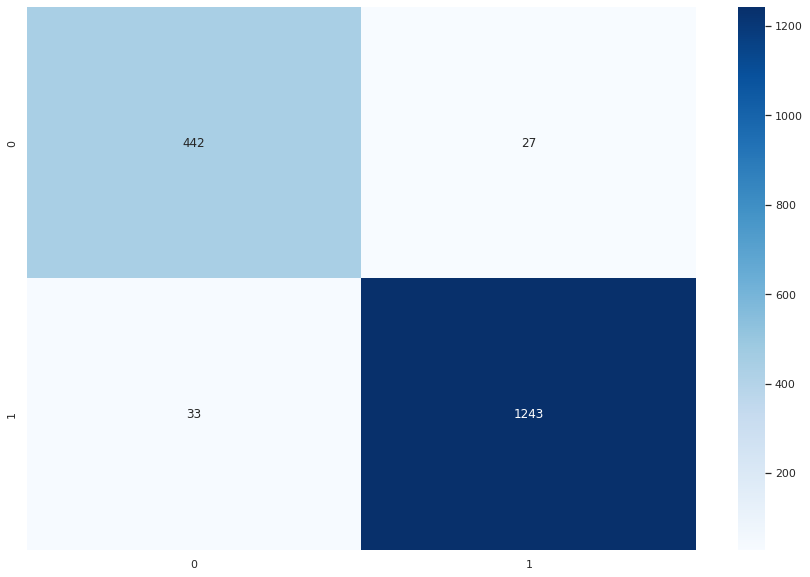

In [57]:
sns.heatmap(confusion_matrix(prediction, ytest), annot=True, fmt='1', cmap='Blues');

## Recall and Precision

In [58]:
print('Model Recall score  : {0:0.4f}'. format(recall_score(ytest, prediction,average='weighted')))
print('Model Precision  : {0:0.4f}'. format(precision_score(ytest, prediction,average='weighted')))

Model Recall score  : 0.9656
Model Precision  : 0.9655


In [59]:
print(classification_report(ytest,prediction))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       475
           1       0.97      0.98      0.98      1270

    accuracy                           0.97      1745
   macro avg       0.96      0.95      0.96      1745
weighted avg       0.97      0.97      0.97      1745

